# Deep learning thực nghiệm 

## Thí nghiệm 2: Kích thước Batch - gia vị cho mô hình

### BS. Lê Ngọc Khả Nhi


## Giới thiệu

Đây là bài thứ hai trong loạt bài về Deep learning thực nghiệm, với mục tiêu giới thiệu với các bạn phương pháp tự học Deep learning một cách chủ động và khoa học thông qua những thí nghiệm nhằm khảo sát về cơ chế của các tham số kỹ thuật trong mô hình Deep learning. 

Như ta biết, phương pháp Deep learning cho phép ta tiến hành riêng biệt 2 công đoạn: xây dựng cấu trúc mạng neuron và xác định các trọng số của mạng này (huấn luyện). Trong bài trước, ta đã thấy rằng năng lực của của mô hình được quy định một phần bởi kiến trúc mạng neuron, như loại layers, vị trí sắp xếp, bao nhiêu layers và bao nhiêu nodes; tuy nhiên chính quy trình huấn luyện lại có ý nghĩa quyết định trong việc khai thác một cách tối ưu cấu trúc này để tạo ra mô hình chuẩn xác.

## Thí nghiệm 2: Khảo sát batch size

Trong bài hôm nay, đối tượng thí nghiệm của chúng ta sẽ là kích thước Batch (batch size), tham số quan trọng của quá trình huấn luyện mô hình. 

Trước hết, batch là gì ? Đó là số đơn vị dữ liệu (instance) được rút ngẫu nhiên từ train_set và được sử dụng cho 1 chu kỳ cập nhật giá trị của error gradient (và giá trị weights). Trong mỗi chu kỳ, một phiên bản tạm thời của mô hình được hình thành dựa vào thông tin mà nó học được từ dữ liệu trong batch hiện thời, phiên bản này được kiểm định trên outcome (cũng trong batch) và sai số của mô hình được cập nhật. 

Batch size có thể dao động từ 1 cho đến toàn bộ trainset và ảnh hưởng đến 2 thứ: Tốc độ training và phẩm chất của error gradient cũng như weights - từ đó quyết định phẩm chất mô hình. Nếu kích thước batch phù hợp (đủ dữ liệu), mỗi bước huấn luyện sẽ có hiệu quả cao, mô hình sẽ nhanh chóng đạt đến trạng thái tốt nhất thay vì mò mẫm trong không gian của hàm loss để tìm ra vị trí tối ưu. Tuy nhiên, kích thước batch quá lớn chưa hẳn là tốt, nó làm chậm tốc độ huấn luyện trong mỗi chu kỳ nhưng lại thực hiện những bước nhảy quá xa và không dừng đúng vị trí tối ưu, trong khi kích thước batch quá nhỏ làm tốc độ huấn luyện nhanh hơn cho mỗi chu kỳ, nhưng chậm đi đến kết quả tối ưu và error không được cập nhật chính xác.

## Mục tiêu và phương pháp

Trong thí nghiệm này, Nhi muốn khảo sát lần lượt 3 điều kiện kích thước batch khác nhau bao gồm:

1) Sử dụng toàn bộ trainset (còn gọi là deterministic hay Batch gradient descent) 

2) Sử dụng mỗi lần một đơn vị dữ liệu (batch size = 1, còn gọi là Stochastic gradient descent hay Online training)

3) Sử dụng một kích thước batch nhất định (thí dụ 32), còn gọi là Minibatch Gradient Descent.

Cuối cùng, Nhi muốn khảo sát ảnh hưởng khi thay đổi kích thước batch từ 2 đến tối đa lên hiệu năng mô hình trong một thí nghiệm tái chọn mẫu 20 lượt.

Thí nghiệm sẽ được thực hiện trên một dữ liệu mô phỏng bằng hàm make_blobs như trong bài trước. Dữ liệu này là 1 bài toán multiclass classification với 1000 đơn vị data, 2 features và 5 classes, chia 50% trainset và testset.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.datasets.samples_generator import *

from sklearn.metrics import cohen_kappa_score as kappa

from numpy import where
from numpy import argmax

Trước hết, ta chuẩn bị dữ liệu mô phỏng chung cho 3 thí nghiệm đầu tiên:

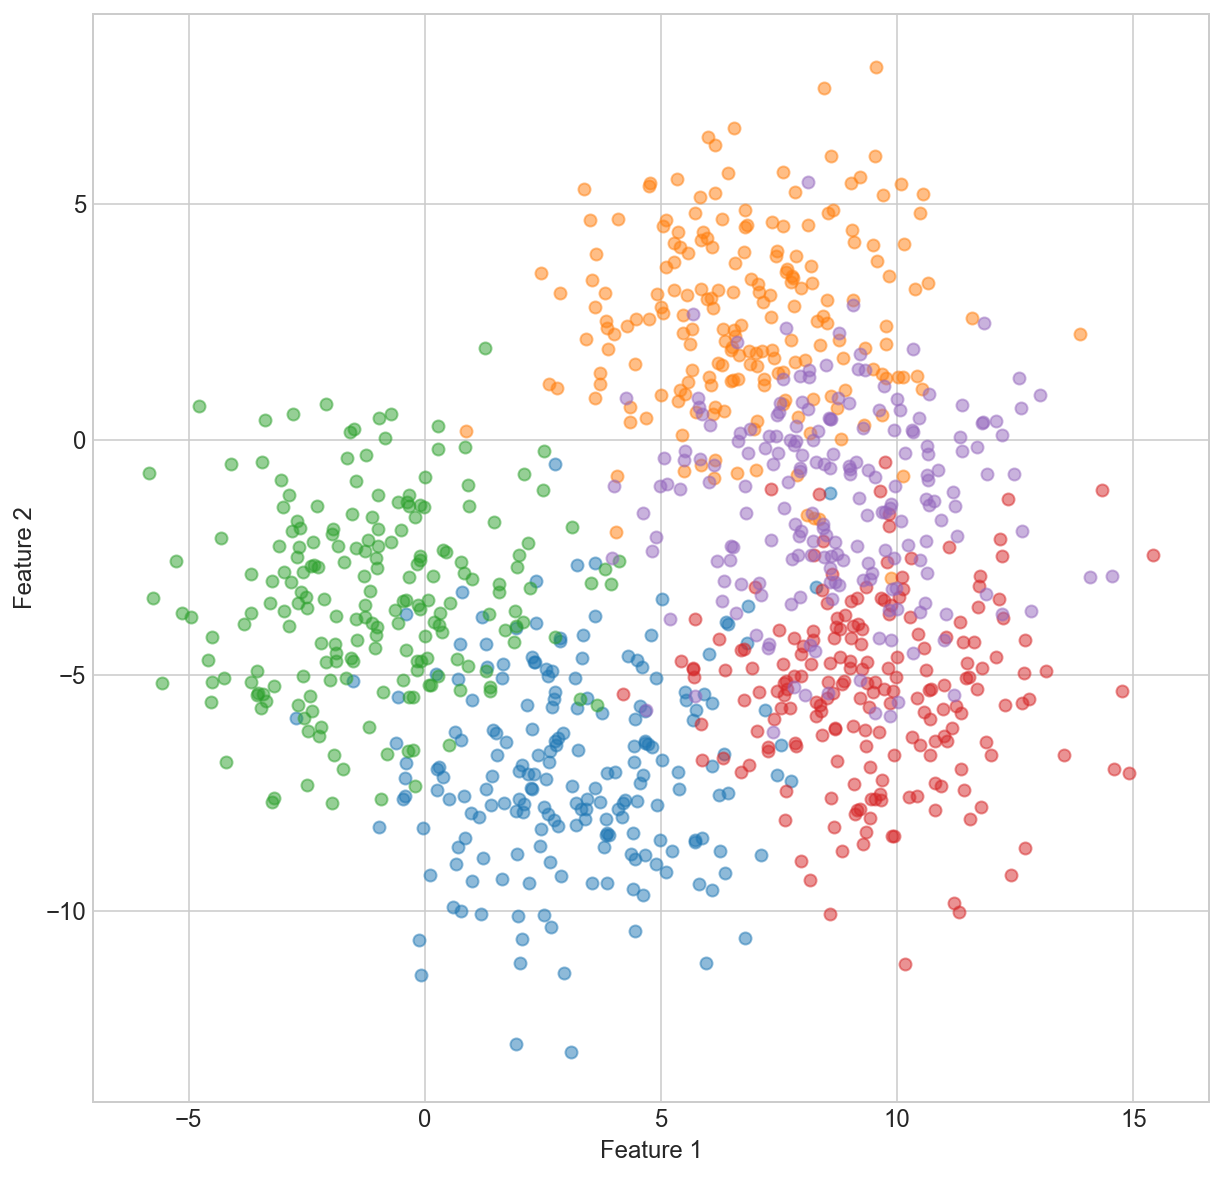

In [63]:
def create_dataset(size=1000,
                   labels=5,
                   n_features=2,
                   noise_std=2,
                   train_ratio=0.5):
    X, y = make_blobs(n_samples = size, 
                      centers = labels, 
                      n_features = n_features, 
                      cluster_std = noise_std)
    plt.figure(figsize=(10,10))
    for class_value in range(5):
        row_id = where(y == class_value)
        plt.scatter(X[row_id, 0], 
                X[row_id, 1],
                alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    y = to_categorical(y)
    n_train = int(size*train_ratio)
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

trainX, trainy, testX, testy = create_dataset()
n_features,n_labels = trainX.shape[1], testy.shape[1]

## Thí nghiệm A: Dùng toàn bộ trainset như 1 batch

Nhi dựng một mô hình Multilayer Perceptron model (MLP) với cấu trúc 1 lớp hidden layer 64 neurons, hàm optimisation là SGD, với tham số learning rate = 0.01 và momentum = 0.9.
Trong thí nghiệm đầu tiên, Nhi huấn luyện mô hình này trong 100 epochs, với batchsize cao nhất có thể là toàn bộ trainset (500 đơn vị).

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 325       
Total params: 517
Trainable params: 517
Non-trainable params: 0
_________________________________________________________________


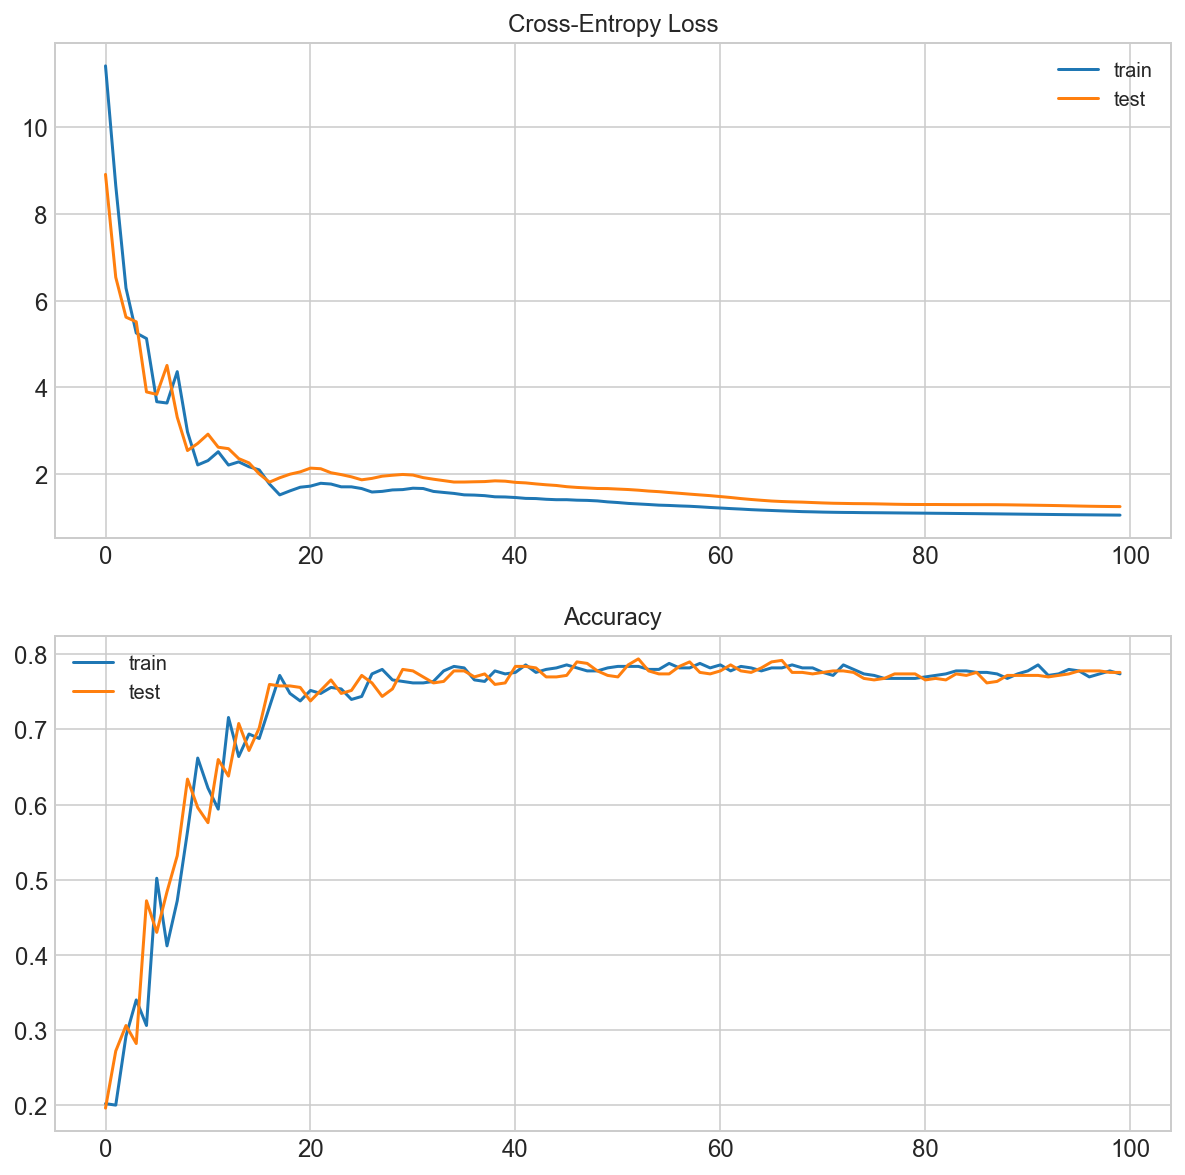

Train ACC: 0.77200, Test ACC: 0.77600


In [64]:
model = Sequential()
model.add(Dense(units=64, 
                input_dim=n_features, 
                activation='relu', 
                kernel_initializer='he_uniform'))
model.add(Dense(units=n_labels, 
                activation='softmax'))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

history = model.fit(trainX, trainy, 
                    validation_data=(testX, testy), 
                    epochs=100, 
                    verbose=0,
                    batch_size=len(trainX))

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Cross-Entropy Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()

plt.show()

print('Train ACC: %.5f, Test ACC: %.5f' % (train_acc, test_acc))

Kết quả của việc sử dụng toàn bộ trainset trong 1 batch đó là tốc độ huấn luyện tương đối chậm cho mỗi epoch, hàm loss diễn tiến kém ổn định, và mô hình cuối cùng có hiệu quả không cao, Accuracy chỉ đạt 0.78 trên tập test. 

## Thí nghiệm B: Sử dụng batch size =1 (Stochastic Gradient Descent)

Cùng một cấu trúc mô hình như trên, trong thí nghiệm tiếp theo Nhi chỉnh batch size về thấp nhất = 1 và cũng huấn luyện trong 100 epochs. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_78 (Dense)             (None, 5)                 325       
Total params: 517
Trainable params: 517
Non-trainable params: 0
_________________________________________________________________


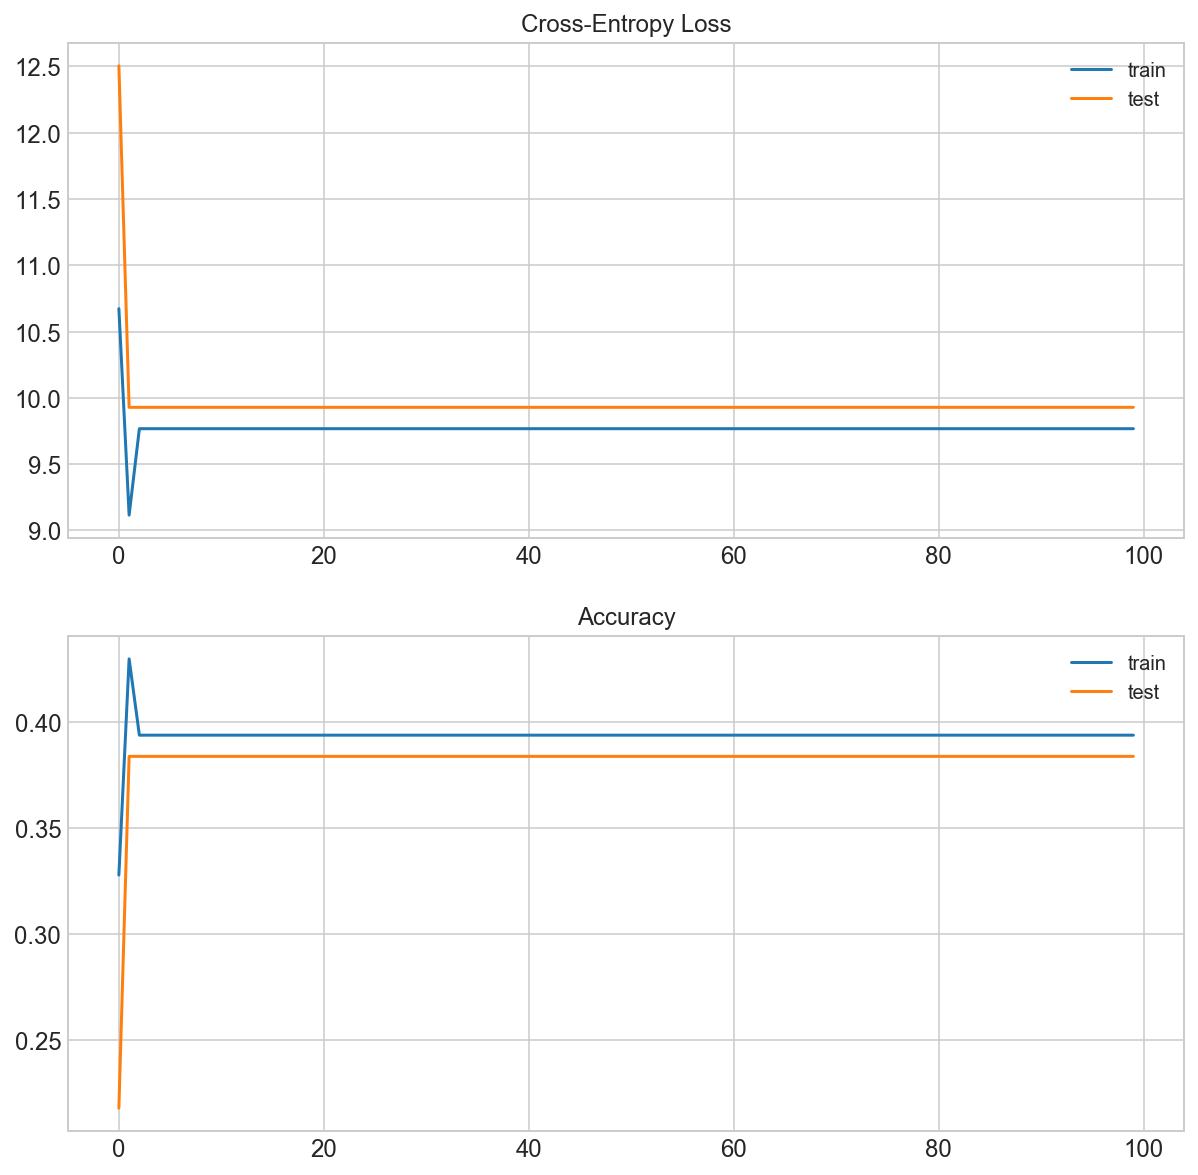

Train ACC: 0.39400, Test ACC: 0.38400


In [65]:
model = Sequential()
model.add(Dense(units=64, 
                input_dim=n_features, 
                activation='relu', 
                kernel_initializer='he_uniform'))
model.add(Dense(units=n_labels, 
                activation='softmax'))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

history = model.fit(trainX, trainy, 
                    validation_data=(testX, testy), 
                    epochs=100, 
                    verbose=0,
                    batch_size=1)

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Cross-Entropy Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()

plt.show()

print('Train ACC: %.5f, Test ACC: %.5f' % (train_acc, test_acc))

Kết quả cho thấy với batch size = 1, mô hình học rất chậm và hiệu năng gần như không cải thiện trong suốt 100 epochs, mô hình cuối cùng có phẩm chất rất kém, với Acc chỉ đạt 0.38

## Thí nghiệm C: Sử dụng batch size = 1 với learning rate thấp

Trong thí nghiệm thứ ba, Nhi thử dùng batch size =1 kết hợp với 1 giá trị learning rate thấp hơn 10 lần (0.001 so với 0.01):

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_80 (Dense)             (None, 5)                 325       
Total params: 517
Trainable params: 517
Non-trainable params: 0
_________________________________________________________________


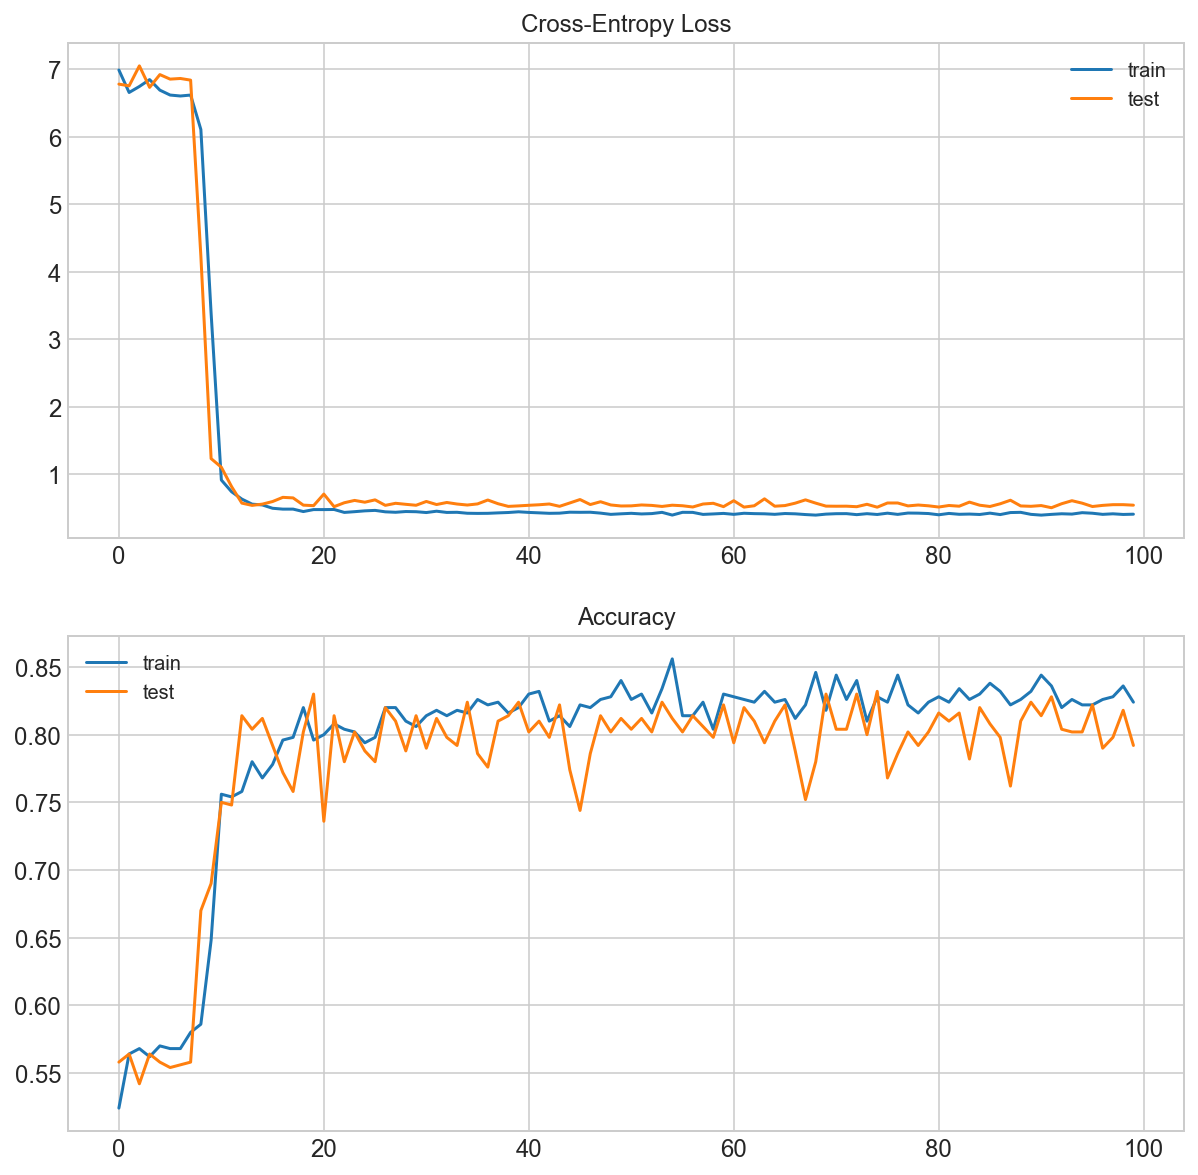

Train ACC: 0.83000, Test ACC: 0.79200


In [66]:
model = Sequential()
model.add(Dense(units=64, 
                input_dim=n_features, 
                activation='relu', 
                kernel_initializer='he_uniform'))
model.add(Dense(units=n_labels, 
                activation='softmax'))

opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

history = model.fit(trainX, trainy, 
                    validation_data=(testX, testy), 
                    epochs=100, 
                    verbose=0,
                    batch_size=1)

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Cross-Entropy Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()

plt.show()

print('Train ACC: %.5f, Test ACC: %.5f' % (train_acc, test_acc))

Kết quả cho thấy khi giảm learning rate xuống còn 0.001, ta có thể dùng batch size =1 để cho ra mô hình có phẩm chất khá tốt: Acc đạt 0.79 trên testset và 0.83 trên trainset. Tuy nhiên diễn tiến của hàm loss cùng giá trị accuracy kém ổn định trên suốt hành trình huấn luyện.

## Thí nghiệm D: Sử dụng batch kích thước nhỏ = 32

Trong thí nghiệm thứ 4, Nhi thử dùng một giá trị batch size nhỏ vừa phải là 32. Đây là giá trị thường được dùng bởi nhiều tác giả và người ta cho rằng 32 là kích thước batch tối ưu cho hầu hết trường hợp.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_82 (Dense)             (None, 5)                 325       
Total params: 517
Trainable params: 517
Non-trainable params: 0
_________________________________________________________________


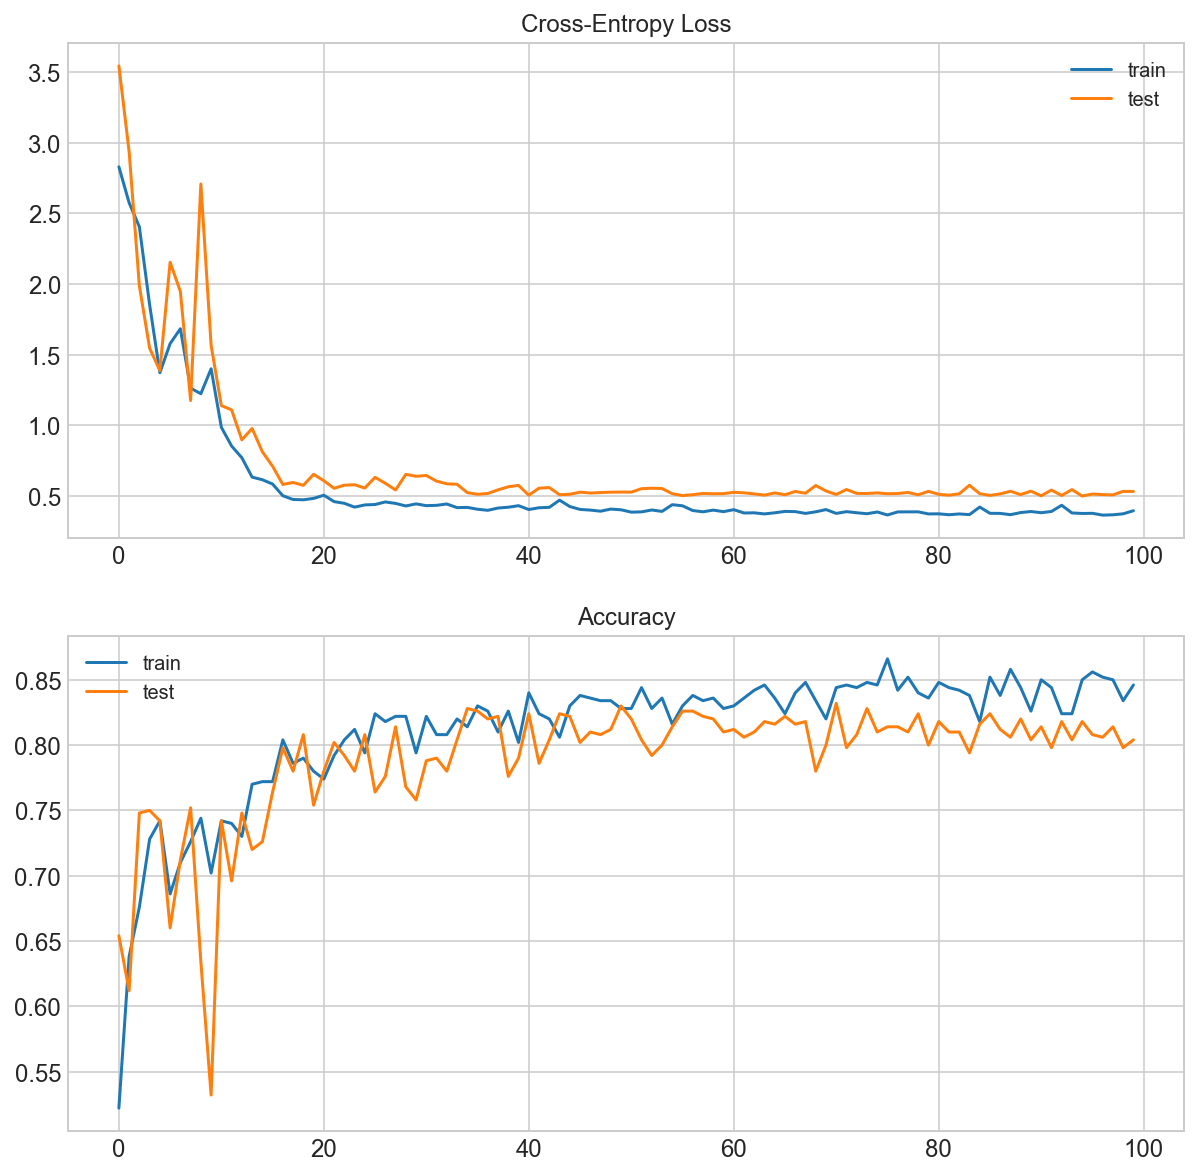

Train ACC: 0.85000, Test ACC: 0.80400


In [67]:
model = Sequential()
model.add(Dense(units=64, 
                input_dim=n_features, 
                activation='relu', 
                kernel_initializer='he_uniform'))
model.add(Dense(units=n_labels, 
                activation='softmax'))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

history = model.fit(trainX, trainy, 
                    validation_data=(testX, testy), 
                    epochs=100, 
                    verbose=0,
                    batch_size=32)

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Cross-Entropy Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()

plt.show()

print('Train ACC: %.5f, Test ACC: %.5f' % (train_acc, test_acc))

Với batch size nhỏ vừa phải (32); đồ thị diễn tiến hàm loss và accuracy trên train và testset khởi hành bằng hình ảnh khá hỗn loạn, nhưng càng về cuối hành trình thì diễn tiến cập nhật của hàm loss càng ổn định, và mô hình sau cùng có độ chính xác rất tốt, vượt trội so với 3 thí nghiệm đầu tiên: Accuracy đạt đến 80.4% trên testset.

## Thí nghiệm E: Khảo sát ảnh hưởng của batch size lên phẩm chất mô hình

Trong thí nghiệm cuối cùng này, Nhi sẽ lần lượt thử 9 giá trị batch size tăng dần, từ 2 cho đến cao nhất là 500 và khảo sát phẩm chất của mô hình sau 100 epochs.

In [78]:
def batchsize_experiment(trainX, trainy, testX, testy, n_batch):
    model = Sequential()
    model.add(Dense(units=32,
                input_dim=n_features,
                activation='relu', 
                kernel_initializer='he_uniform'))
    model.add(Dense(units=n_labels, 
                activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
    history = model.fit(trainX, trainy, 
                        validation_data=(testX, testy), 
                        epochs=100, 
                        verbose=0, 
                        batch_size=n_batch)
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.title('batch size='+str(n_batch))
    y_pred = model.predict_classes(testX)
    y_truth = argmax(testy, axis=1)
    kap_coef = kappa(y_truth, y_pred)
    _, acc = model.evaluate(testX, testy, verbose=0)
    return acc, kap_coef

Conditions|Accuracy|Cohen Kappa
batch size=2: 0.72800 0.66068
batch size=4: 0.80800 0.76017
batch size=8: 0.78400 0.72956
batch size=16: 0.79800 0.74753
batch size=32: 0.80400 0.75487
batch size=64: 0.81000 0.76243
batch size=128: 0.80400 0.75495
batch size=256: 0.79200 0.73989
batch size=500: 0.78600 0.73246


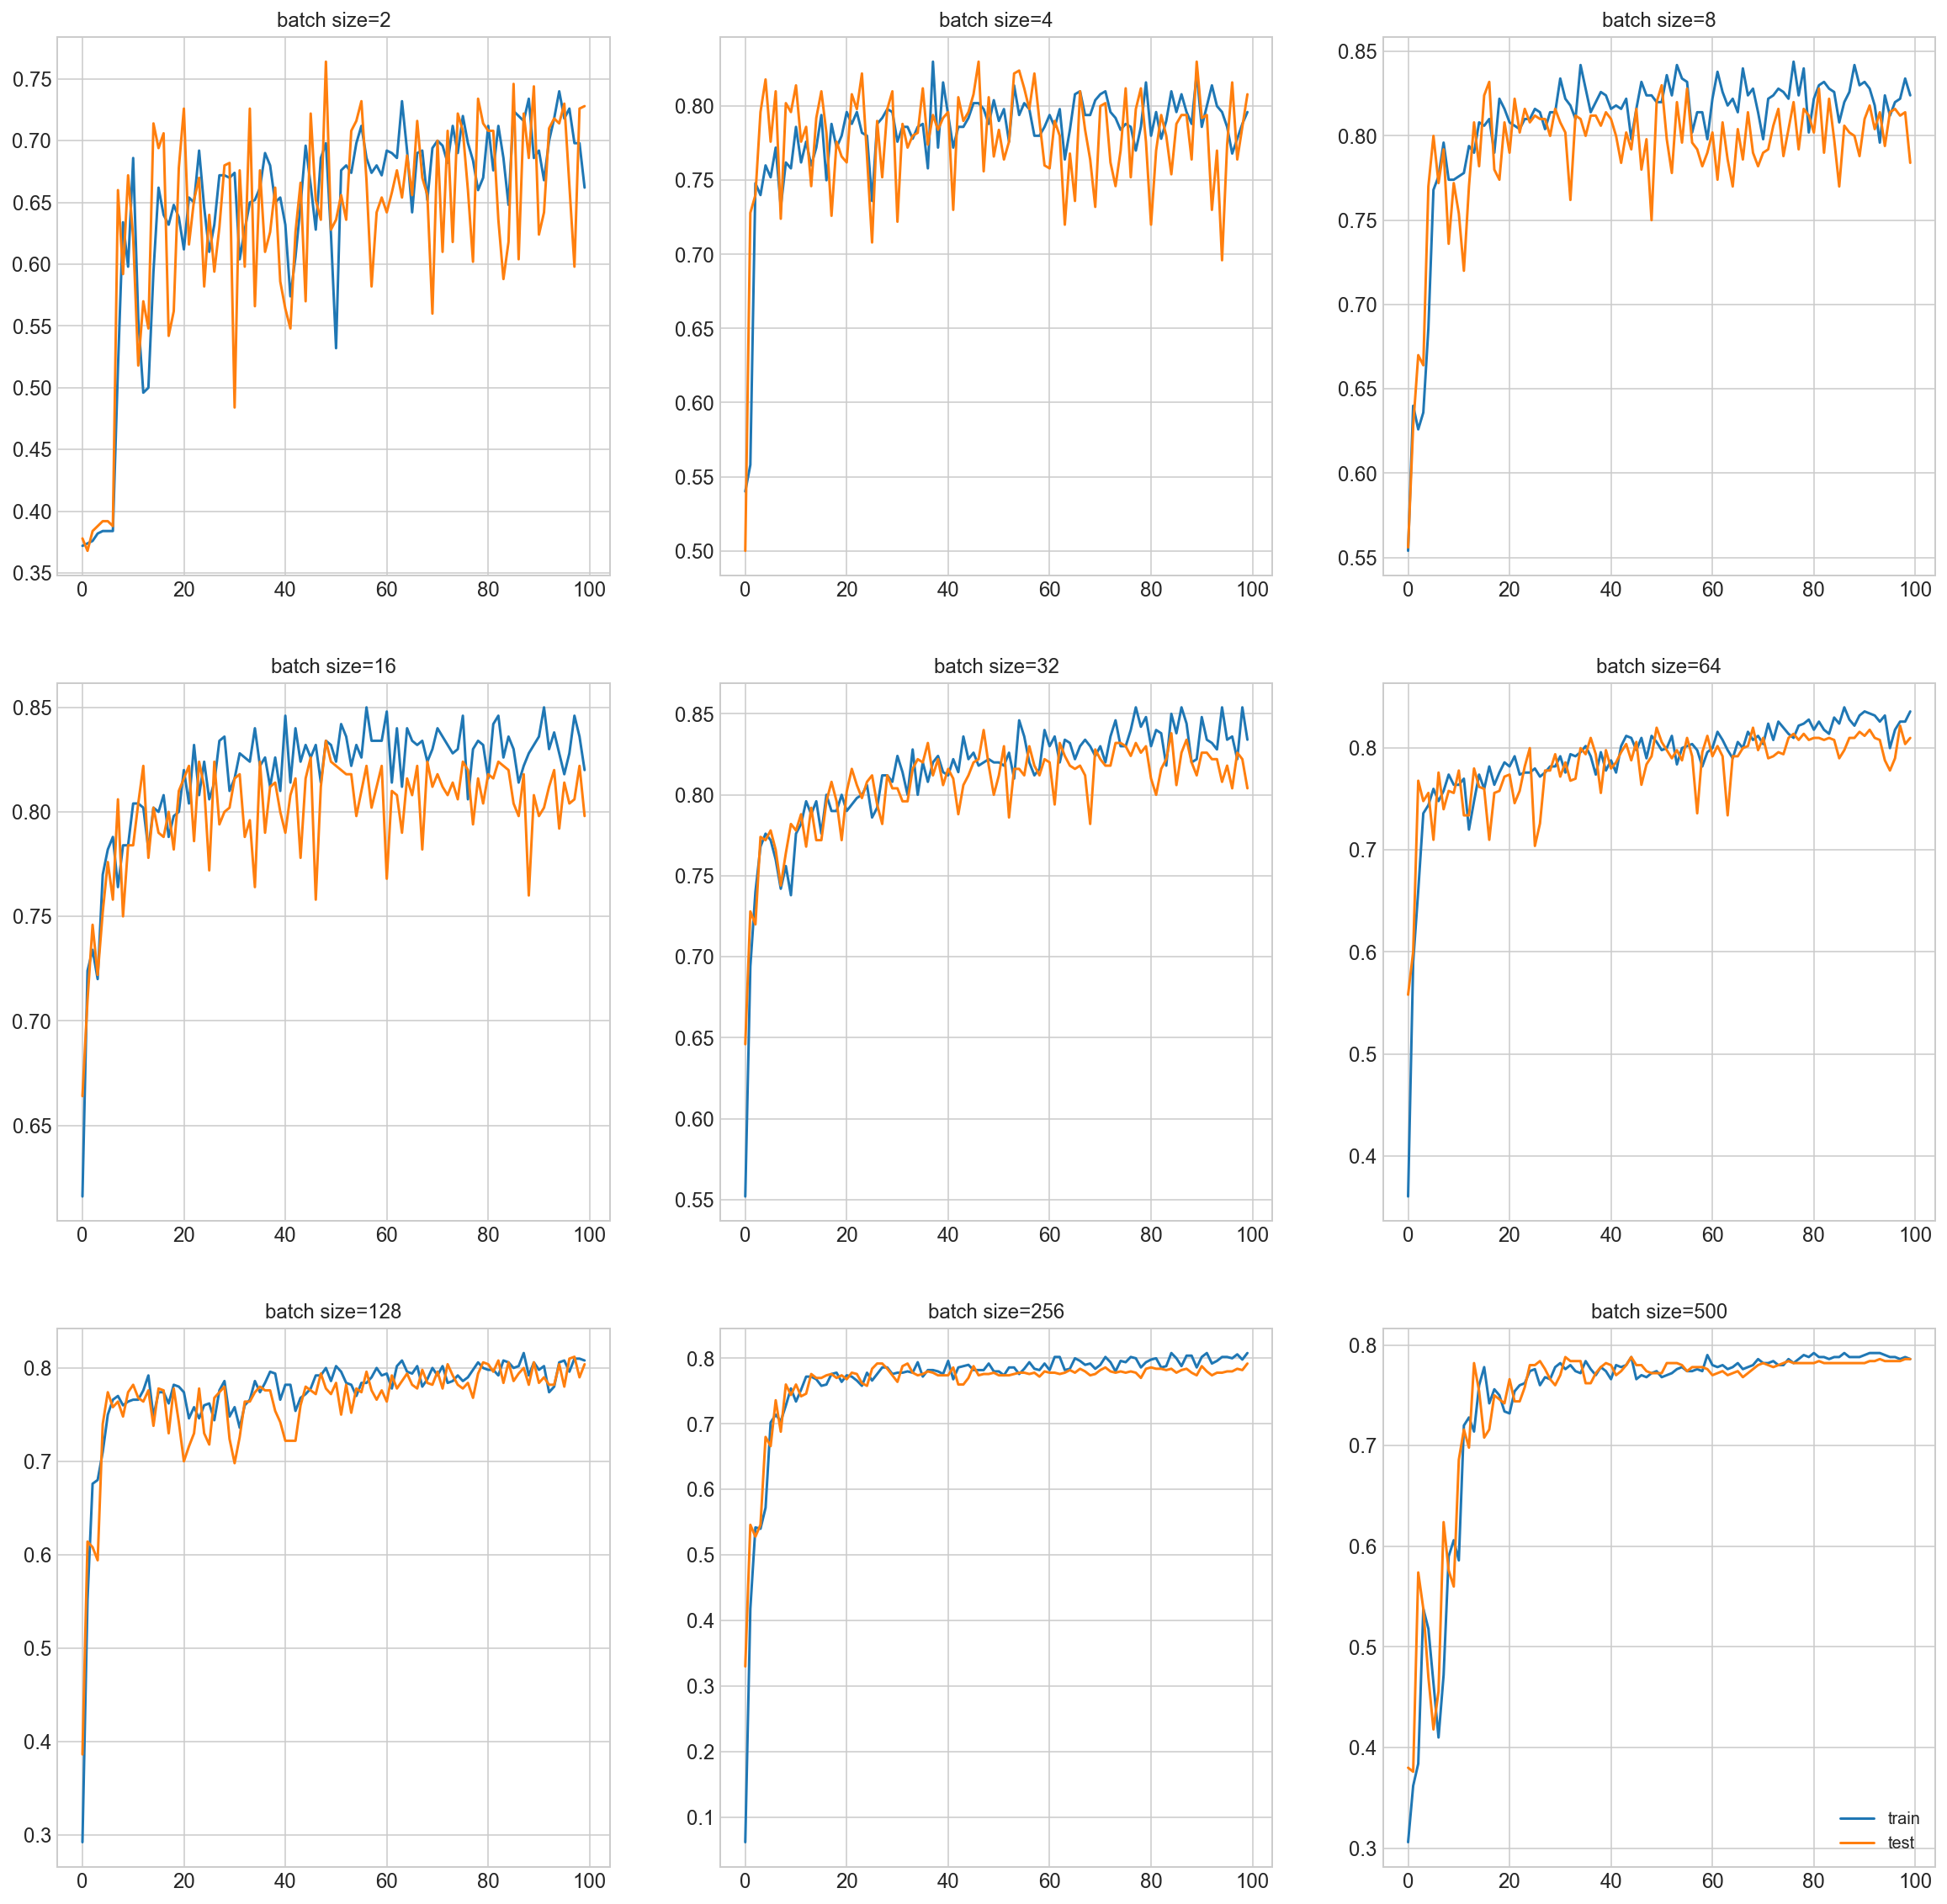

No handles with labels found to put in legend.


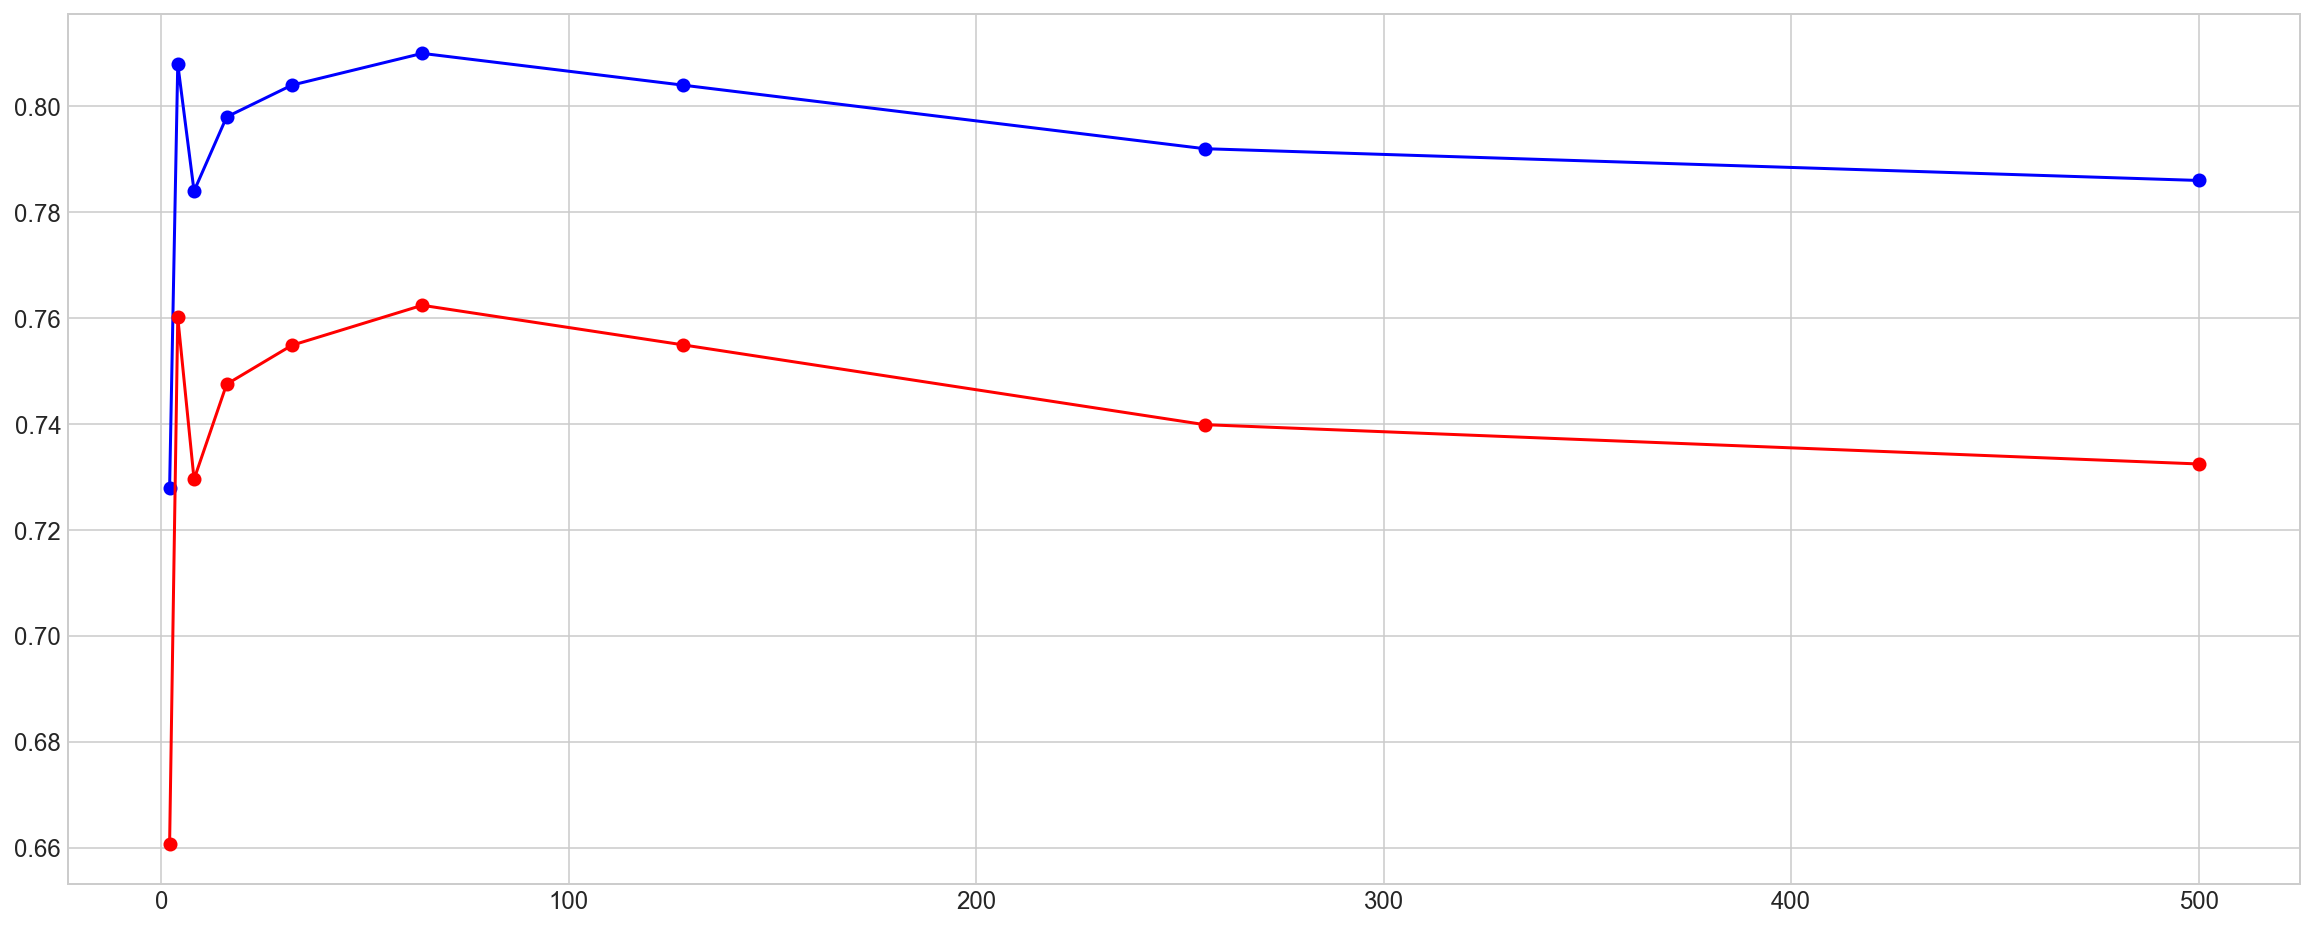

In [80]:
acc_list=[]
kappa_list = []

batch_sizes = [2,4,8,16,32,64,128,256,len(trainX)]

plt.figure(figsize=(20,20))
print('Conditions|Accuracy|Cohen Kappa')
for i in range(len(batch_sizes)):
    plot_id = 330 + (i+1)
    plt.subplot(plot_id)
    acc,kap = batchsize_experiment(trainX, trainy, 
                                   testX, testy, 
                                   n_batch = batch_sizes[i])
    acc_list.append(acc)
    kappa_list.append(kap)
    print('batch size=%d: %.5f %.5f'%(batch_sizes[i], acc, kap))

plt.legend()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(batch_sizes,acc_list,"bo-")
plt.plot(batch_sizes,kappa_list,"ro-")
plt.legend()
plt.show()

Dựa vào kết quả này, ta có thể thấy rằng: batch size càng thấp thì diễn tiến của hàm loss càng kém ổn định, dùng một batchsize phù hợp (không quá nhỏ, cũng không quá lớn), mô hình có thể học nhanh hơn, hiệu quả hơn và sớm đạt trạng thái tối ưu cũng như cho ra phẩm chất tốt hơn. Batch size quá lớn đẩy nhanh tốc độ huấn luyện nhưng mô hình sau cùng có phẩm chất kém hơn.

Do đây chỉ là một trường hợp cá thể, nên Nhi sẽ lặp lại thí nghiệm vừa rồi cho 20 lượt tái chọn mẫu khác nhau. Để tối ưu hóa phẩm chất mô hình ở từng điều kiện, Nhi áp dụng thêm chế độ early stoping để ngừng hành trình huấn luyện khi hàm loss trên tập testset không giảm có ý nghĩa sau 5 epochs.

In [91]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

def sim_dataset(size=1000,
                   labels=5,
                   n_features=2,
                   noise_std=2,
                   train_ratio=0.5):
    X, y = make_blobs(n_samples = size, 
                      centers = labels, 
                      n_features = n_features, 
                      cluster_std = noise_std)
    y = to_categorical(y)
    n_train = int(size*train_ratio)
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

def batchsize_experiment_short(trainX, trainy, testX, testy, n_batch):
    n_features,n_labels = trainX.shape[1], testy.shape[1]
    model = Sequential()
    model.add(Dense(units=32,
                input_dim=n_features,
                activation='relu', 
                kernel_initializer='he_uniform'))
    model.add(Dense(units=n_labels, 
                activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
    model.fit(trainX,trainy, epochs=100,
              validation_data=(testX, testy),
              batch_size=n_batch,
              verbose=0,
              callbacks=[early_stop])
    y_pred = model.predict_classes(testX)
    y_truth = argmax(testy, axis=1)
    kap_coef = kappa(y_truth, y_pred)
    _, acc = model.evaluate(testX, testy, verbose=0)
    return acc, kap_coef

df = pd.DataFrame()

batch_sizes = [2,4,8,16,32,64,128,256,500]

for resample_idx in range(20):
    print('-----------------------')
    print('Sample N°=%d:' % resample_idx)
    print('-----------------------')
    trainX, trainy, testX, testy = sim_dataset()
    for i in range(len(batch_sizes)):
        acc,kap = batchsize_experiment_short(trainX, trainy,
                                             testX, testy, 
                                             n_batch = batch_sizes[i])
        print('batch size=%d: %.5f %.5f'%(batch_sizes[i], acc, kap))
        df = df.append({'resample': str(resample_idx),
                        'batch_size': str(batch_sizes[i]),
                        'Accuracy': acc,
                        'Kappa': kap}, ignore_index=True)

-----------------------
Sample N°=0:
-----------------------
batch size=2: 0.85600 0.81959
batch size=4: 0.79800 0.74681
batch size=8: 0.84200 0.80203
batch size=16: 0.84600 0.80717
batch size=32: 0.84000 0.79978
batch size=64: 0.83400 0.79223
batch size=128: 0.84600 0.80716
batch size=256: 0.81200 0.76486
batch size=500: 0.83800 0.79718
-----------------------
Sample N°=1:
-----------------------
batch size=2: 0.79000 0.73737
batch size=4: 0.79600 0.74480
batch size=8: 0.79400 0.74236
batch size=16: 0.80600 0.75732
batch size=32: 0.82000 0.77484
batch size=64: 0.81200 0.76483
batch size=128: 0.80200 0.75243
batch size=256: 0.80800 0.75980
batch size=500: 0.66600 0.58141
-----------------------
Sample N°=2:
-----------------------
batch size=2: 0.90200 0.87757
batch size=4: 0.80000 0.74863
batch size=8: 0.83800 0.79816
batch size=16: 0.80200 0.75117
batch size=32: 0.86800 0.83532
batch size=64: 0.86800 0.83521
batch size=128: 0.87800 0.84764
batch size=256: 0.85800 0.82236


Exception ignored in: <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x000001C3A7EB34A8>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 39, in __del__
    c_api.TF_DeleteStatus(self.status)
AttributeError: 'ScopedTFStatus' object has no attribute 'status'


batch size=500: 0.84400 0.80452
-----------------------
Sample N°=3:
-----------------------
batch size=2: 0.75800 0.69645
batch size=4: 0.70400 0.63099
batch size=8: 0.65400 0.56655
batch size=16: 0.66800 0.58521
batch size=32: 0.70400 0.62954
batch size=64: 0.67400 0.59032
batch size=128: 0.67400 0.59153
batch size=256: 0.66600 0.58121
batch size=500: 0.34600 0.18870
-----------------------
Sample N°=4:
-----------------------
batch size=2: 0.82800 0.78586
batch size=4: 0.89200 0.86459
batch size=8: 0.87000 0.83733
batch size=16: 0.87000 0.83753
batch size=32: 0.88200 0.85211
batch size=64: 0.88600 0.85714
batch size=128: 0.88600 0.85724
batch size=256: 0.89600 0.86976
batch size=500: 0.81800 0.77109
-----------------------
Sample N°=5:
-----------------------
batch size=2: 0.75000 0.68645
batch size=4: 0.74000 0.67545
batch size=8: 0.55000 0.44166
batch size=16: 0.72200 0.65303
batch size=32: 0.70600 0.63365
batch size=64: 0.52800 0.40570
batch size=128: 0.69200 0.61587
batch size=2

Kết quả Accuracy và Kappa trung bình được trình bày trong 2 biểu đồ sau đây:

Text(0,0.5,'Accuracy')

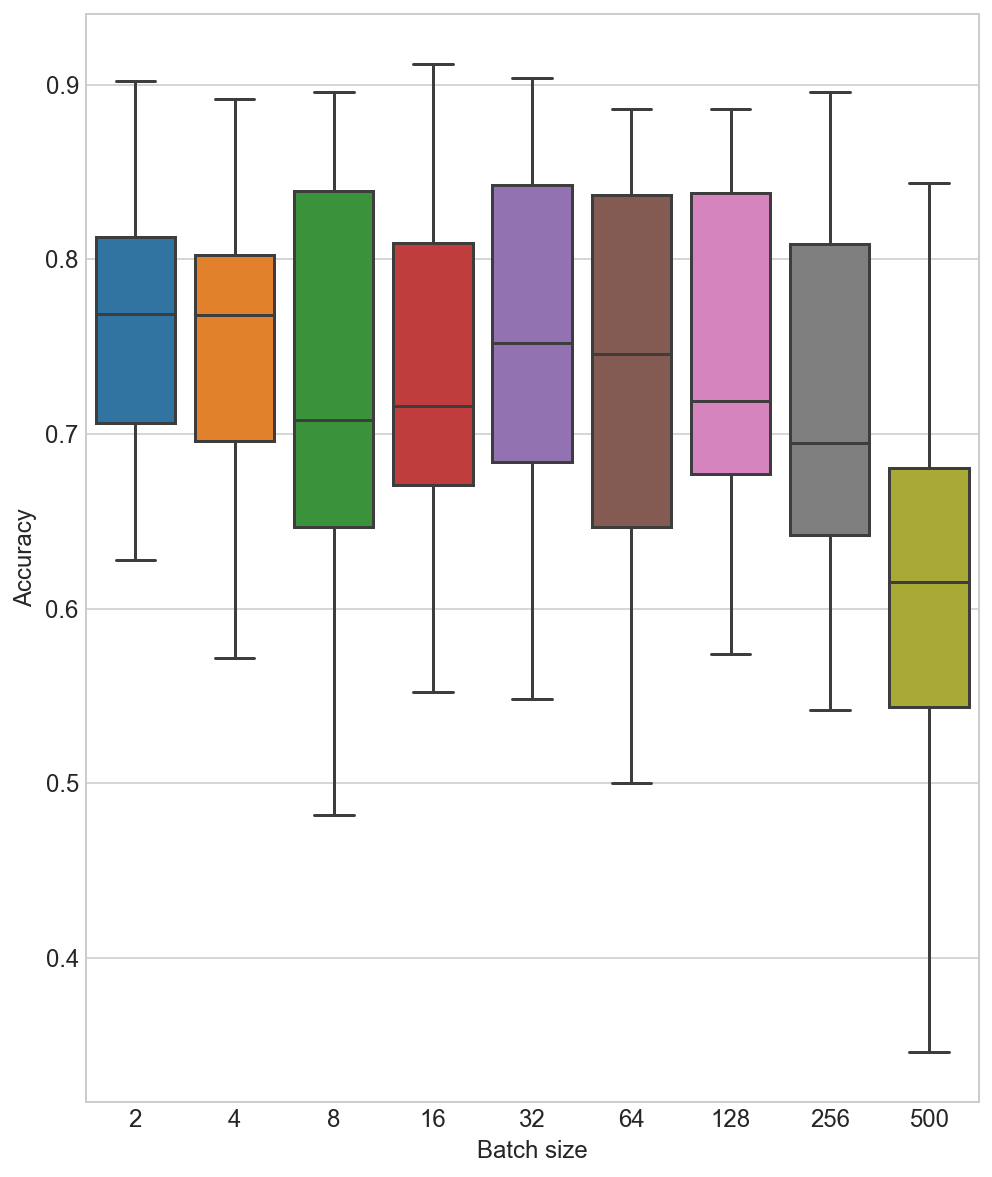

In [96]:
plt.figure(figsize=(8,10))
sns.boxplot(x='batch_size',y='Accuracy',data=df,
            order=['2','4','8','16','32','64','128','256','500'])
plt.xlabel('Batch size')
plt.ylabel('Accuracy')

Text(0,0.5,'Kappa')

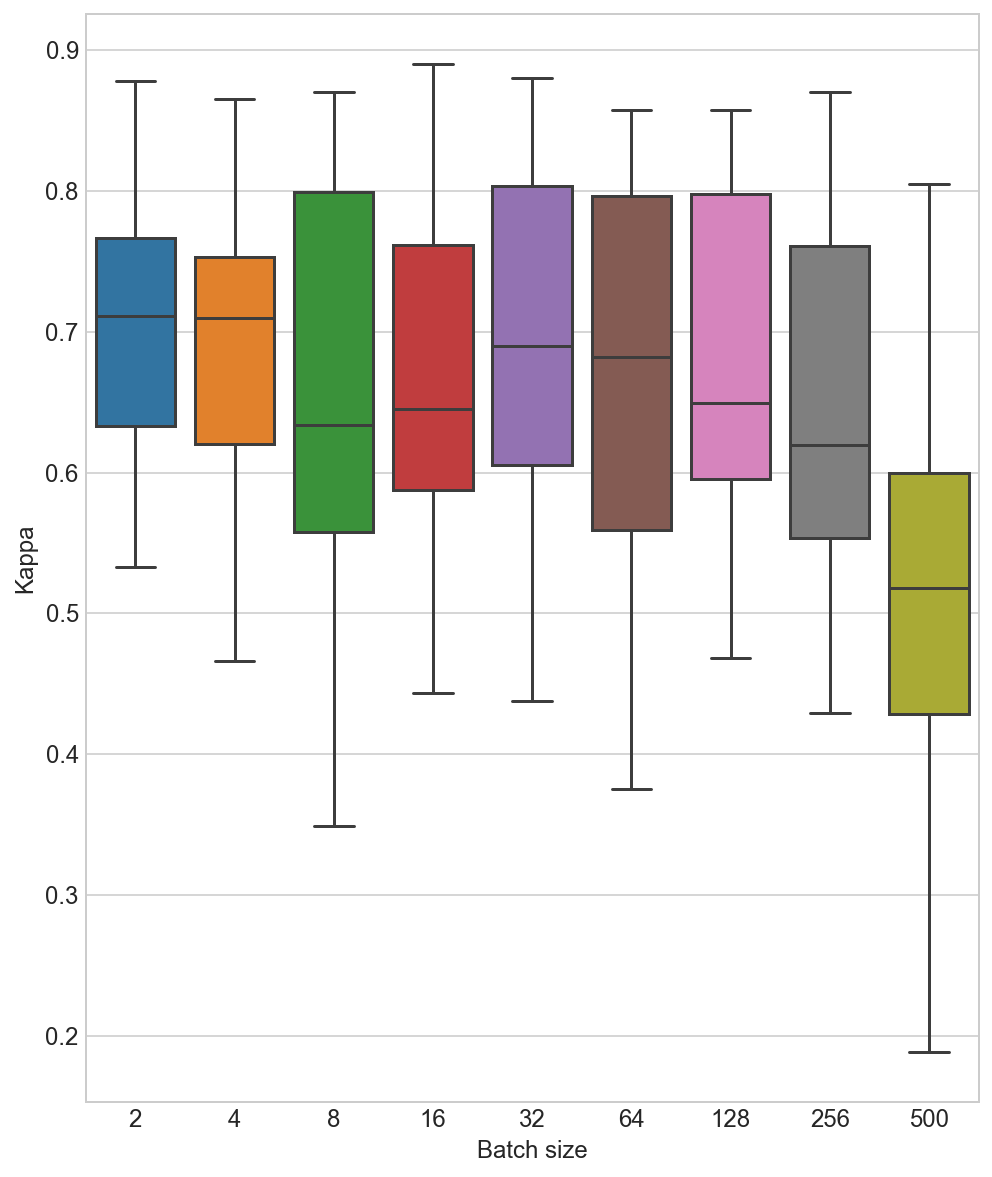

In [97]:
plt.figure(figsize=(8,10))
sns.boxplot(x='batch_size',y='Kappa',data=df,
            order=['2','4','8','16','32','64','128','256','500'])
plt.xlabel('Batch size')
plt.ylabel('Kappa')

Kết quả này khẳng định rằng sử dụng batch size quá lớn không phải là ý tưởng hay, vì luôn cho ra mô hình có phẩm chất kém hơn so với batch size nhỏ. Lưu ý rằng ở đây learning rate được giảm còn 0.001, nên rất phù hợp với batch size nhỏ (2 và 4)

## Kết luận

Qua 6 thí nghiệm vừa thực hiện trong bài, ta có thể rút ra một số kết luận như sau:

Batch size là một tham số có ý nghĩa quan trọng cho phép kiểm soát hành vi của mô hình trong hành trình huấn luyện, quyết định tốc độ di chuyển, tính ổn định và tính chính xác của việc cập nhật nội dung mô hình cũng như khả năng mô hình đạt đến trạng thái tối ưu - từ đó cho ra phẩm chất tối ưu của mô hình sau cùng. Như vậy, điều chỉnh batch size cũng như thêm bớt gia vị khi bạn nấu ăn: một batch size nhỏ vừa đủ luôn tốt hơn batch size quá lớn. Batch size phải phù hợp với learning rate và kích thước trainset. 

Tạm biệt các bạn và hẹn gặp lại trong thí nghiệm tiếp theo.